In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import cvxpy as cp
import time

In [ ]:
# Load datasets
def load_data(file_path):
    label = []
    data = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        # Read only the first 1000 rows for training
        for i, row in enumerate(reader):
            if i >= 1000:
                break
            label.append(int(row[0]))
            data.append([int(x) for x in row[1:]])
    return np.array(label), np.array(data).T

train_label, train_data = load_data('mnist_train.csv')
test_label, test_data = load_data('mnist_test.csv')

# Normalise the data
train_data = train_data / 255.0
test_data = test_data / 255.0


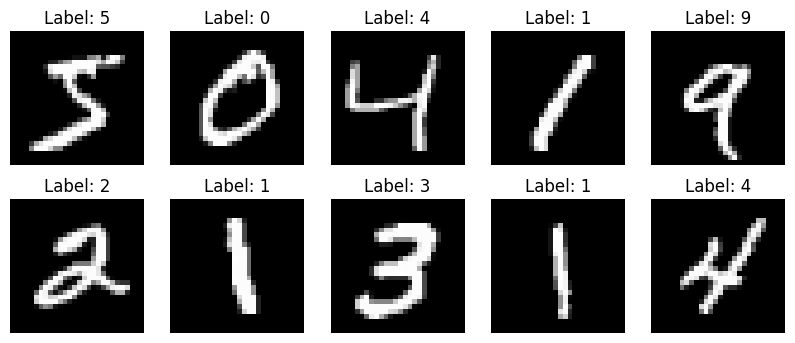

Mean Sparsity Level: 148.42
95th Percentile of Sparsity Level: 212.04999999999995


In [4]:

# Display some images from the training set
def display_images(labels, data, num_images=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(data[:, i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Label: {int(labels[i])}')
        ax.axis('off')
    plt.show()
# Display the first 10 images from the training set
display_images(train_label, train_data, num_images=10)

# Print sparsity level of the training data (average number of non-zero elements per image)
mean_sparsity = np.mean(np.sum(train_data != 0, axis=0))
percentile_95_sparsity = np.percentile(np.sum(train_data != 0, axis=0), 95)

print(f"Mean Sparsity Level: {mean_sparsity}")
print(f"95th Percentile of Sparsity Level: {percentile_95_sparsity}")

In [5]:
# Create random measurement matrices
A25 = np.random.randn(25, 784)
A100 = np.random.randn(100, 784)
A200 = np.random.randn(200, 784)
A500 = np.random.randn(500, 784)
A1000 = np.random.randn(1000, 784)
A2000 = np.random.randn(2000, 784)

# Normalise columns
def normalise_columns(A):
    norms = np.linalg.norm(A, axis=1, keepdims=True)
    return A / norms
A25 = normalise_columns(A25)
A100 = normalise_columns(A100)
A200 = normalise_columns(A200)
A500 = normalise_columns(A500)
A1000 = normalise_columns(A1000)
A2000 = normalise_columns(A2000)

# Apply measurement model to the data
def one_bit_measure(A, X):
    Y = np.sign(A @ X)
    return Y

# Apply measurement model to the training and test data
Y_25 = one_bit_measure(A25, train_data)
Y_100 = one_bit_measure(A100, train_data)
Y_200 = one_bit_measure(A200, train_data)
Y_500 = one_bit_measure(A500, train_data)
Y_1000 = one_bit_measure(A1000, train_data)
Y_2000 = one_bit_measure(A2000, train_data)

In [6]:
def reconstruct_LP(y, A):
    """
    Solves the 1-bit CS problem using LP
    Args:
        y: 1-bit measurements (vector of ±1).
        A: Measurement matrix (m x n).
    Returns:
        Reconstructed signal x (not normalized).
    """
    m, n = A.shape
    x = cp.Variable(n)
    u = cp.Variable(n)  # Dummy variables for ℓ1 relaxation

    objective = cp.Minimize(cp.sum(u))
    constraints = [
        x <= u,                                     # 
        -x <= u,                                    # equivalent to |x_i| ≤ u_i)
        cp.multiply(y, A @ x) >= 0,                 # sign(Ax) = y
        (1/m) * cp.sum(cp.multiply(y, A @ x)) >= 1  # |Ax|_1 >= m
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS, verbose=False)

    # Set negative values to zero
    x.value[x.value < 0] = 0
    return x.value

# Batch reconstruction of multiple images using the LP method
def batch_reconstruct_LP(Y, A, num_images=10):
    X_hat = []
    times = []
    for i in range(num_images):
        y = Y[:,i]

        # Measure the time taken for the first reconstruction
        time_start = time.time()

        x_hat = reconstruct_LP(y, A)

        time_end = time.time()

        X_hat.append(x_hat)
        times.append(time_end - time_start)
    return np.array(X_hat).T, np.mean(times)

In [7]:

# Reconstruct images for different measurement matrices
X_hat_25_LP, t_25 = batch_reconstruct_LP(Y_25, A25)
X_hat_100_LP, t_100 = batch_reconstruct_LP(Y_100, A100)
X_hat_200_LP, t_200 = batch_reconstruct_LP(Y_200, A200)
X_hat_500_LP, t_500 = batch_reconstruct_LP(Y_500, A500)
X_hat_1000_LP, t_1000 = batch_reconstruct_LP(Y_1000, A1000, num_images=1) # Only reconstructing one image due to long processing time
X_hat_2000_LP, t_2000 = batch_reconstruct_LP(Y_2000, A2000, num_images=1)

LP_times = [t_25, t_100, t_200, t_500, t_1000, t_2000]

In [37]:
# Display reconstructed images
def display_reconstructed_images(X, num_images=10, m = None):
    plt.figure(figsize=(10, 4))

    if m is not None:
        plt.suptitle(f'Reconstructed Images from {m} measurements', fontsize=16)

    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(X[:,i].reshape(28, 28), cmap='gray', vmin=0)
        ax.axis('off')
    plt.show()
    
# Uncomment the following lines to display the reconstructed images
# display_reconstructed_images(X_hat_25_LP, num_images=10, m=25)
# display_reconstructed_images(X_hat_100_LP, num_images=10, m=100)
# display_reconstructed_images(X_hat_200_LP, num_images=10, m=200)
# display_reconstructed_images(X_hat_500_LP, num_images=10, m=500)
# display_reconstructed_images(X_hat_1000_LP, num_images=1, m=1000)
# display_reconstructed_images(X_hat_2000_LP, num_images=1, m=2000)

In [9]:
def reconstruct_NBIHT(y, A, s, tau=np.sqrt(np.pi / 2), max_iter=1000, tol=1e-6):
    """
    Reconstruct a sparse signal using the Normalized Binary Iterative Hard Thresholding (NBIHT) algorithm.
    
    Parameters:
    - y: Measurement vector (sign(Ax)), shape (m,)
    - A: Measurement matrix, shape (m, N)
    - s: Sparsity level (number of non-zero entries).
    - tau: Step size for the update.
    - max_iter: Maximum number of iterations.
    - tol: Tolerance for stopping criterion (norm difference between consecutive x_k).
    
    Returns:
    - x: Reconstructed sparse signal, shape (N,)
    """
    m, N = A.shape
    
    # Initialize x0 as a random unit norm s-sparse vector
    x_k = np.zeros(N)
    indices = np.random.choice(N, s, replace=False)
    x_k[indices] = np.random.randn(s)
    x_k = x_k / np.linalg.norm(x_k)
    
    for _ in range(max_iter):
        # Compute z_{k+1}
        residual = y - np.sign(A @ x_k)
        z_k1 = x_k + (tau / m) * (A.T @ residual)
        
        # Project to s-sparse vector (hard thresholding)
        indices = np.argsort(np.abs(z_k1))[-s:]
        x_tilde = np.zeros(N)
        x_tilde[indices] = z_k1[indices]
        
        # Normalize
        norm_x_tilde = np.linalg.norm(x_tilde)
        x_k1 = x_tilde / norm_x_tilde
        
        # Check stopping criterion
        if np.linalg.norm(x_k1 - x_k) < tol:
            break
        
        x_k = x_k1
    
    # Set negative values to zero
    x_k[x_k < 0] = 0
    return x_k

def batch_reconstruct_NBIHT(Y, A, s, tau=np.sqrt(np.pi / 2), max_iter=1000, tol=1e-7, num_images=10):
    X_hat = []
    times = []
    for i in range(num_images):
        y = Y[:, i]
        # Measure the time taken for the first reconstruction
        time_start = time.time()

        x_hat = reconstruct_NBIHT(y, A, s, tau=tau, max_iter=max_iter, tol=tol)

        time_end = time.time()

        X_hat.append(x_hat)
        times.append(time_end - time_start)
    return np.array(X_hat).T, np.mean(times)

In [ ]:
s = int(percentile_95_sparsity)  # Use integer value for sparsity level

# Reconstruct images using NBIHT for different measurement matrices
X_hat_25_NBIHT, t_25 = batch_reconstruct_NBIHT(Y_25, A25, s)
X_hat_100_NBIHT, t_100 = batch_reconstruct_NBIHT(Y_100, A100, s)
X_hat_200_NBIHT, t_200 = batch_reconstruct_NBIHT(Y_200, A200, s)
X_hat_500_NBIHT, t_500 = batch_reconstruct_NBIHT(Y_500, A500, s)
X_hat_1000_NBIHT, t_1000 = batch_reconstruct_NBIHT(Y_1000, A1000, s)
X_hat_2000_NBIHT, t_2000 = batch_reconstruct_NBIHT(Y_2000, A2000, s)

NBIHT_times = [t_25, t_100, t_200, t_500, t_1000, t_2000]


In [39]:

# Uncomment the following lines to display the reconstructed images using NBIHT
# display_reconstructed_images(X_hat_25_NBIHT, num_images=10, m=25)
# display_reconstructed_images(X_hat_100_NBIHT, num_images=10, m=100)
# display_reconstructed_images(X_hat_200_NBIHT, num_images=10, m=200)
# display_reconstructed_images(X_hat_500_NBIHT, num_images=10, m=500)
# display_reconstructed_images(X_hat_1000_NBIHT, num_images=1, m=1000)
# display_reconstructed_images(X_hat_2000_NBIHT, num_images=1, m=2000)

In [12]:
def compute_metrics(X_hat, X_true):
    """
    Compute average noise (MSE) and accuracy (sign agreement) for reconstructed images.
    Args:
        X_hat: Reconstructed images, shape (784, num_images)
        X_true: Ground truth images, shape (784, num_images)
    Returns:
        avg_mse: Average mean squared error
        avg_snr: Average signal-to-noise ratio (SNR)
    """
    # Normalise both X_hat and X_true
    X_hat = X_hat / np.linalg.norm(X_hat, axis=0, keepdims=True)
    X_true = X_true / np.linalg.norm(X_true, axis=0, keepdims=True)
    
    mse = np.mean((X_hat - X_true) ** 2, axis=0)

    snr = 10 * np.log10(np.sum(X_true ** 2, axis=0) / np.sum((X_hat - X_true) ** 2, axis=0))
    
    # Average out metrics across all images
    avg_mse = np.mean(mse)
    avg_snr = np.mean(snr)
    return avg_mse, avg_snr

LP Reconstruction with 25 measurements: MSE = 2.3449e-03, SNR = -2.6303, Time = 0.0368 s
LP Reconstruction with 100 measurements: MSE = 2.1133e-03, SNR = -2.1824, Time = 0.1553 s
LP Reconstruction with 200 measurements: MSE = 1.8004e-03, SNR = -1.4766, Time = 0.4323 s
LP Reconstruction with 500 measurements: MSE = 1.0841e-03, SNR = 0.9091, Time = 2.9389 s
LP Reconstruction with 1000 measurements: MSE = 4.8204e-04, SNR = 4.2260, Time = 17.2465 s
LP Reconstruction with 2000 measurements: MSE = 1.1946e-04, SNR = 10.2844, Time = 86.0400 s
NBIHT Reconstruction with 25 measurements: MSE = 2.2635e-03, SNR = -2.4889, Time = 0.0019 s
NBIHT Reconstruction with 100 measurements: MSE = 2.1342e-03, SNR = -2.2291, Time = 0.0052 s
NBIHT Reconstruction with 200 measurements: MSE = 1.9880e-03, SNR = -1.9218, Time = 0.0196 s
NBIHT Reconstruction with 500 measurements: MSE = 1.4452e-03, SNR = -0.5286, Time = 0.0520 s
NBIHT Reconstruction with 1000 measurements: MSE = 7.5400e-04, SNR = 2.3915, Time = 0.16

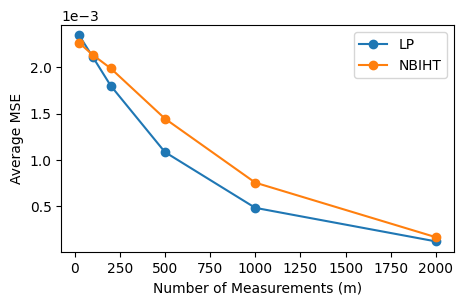

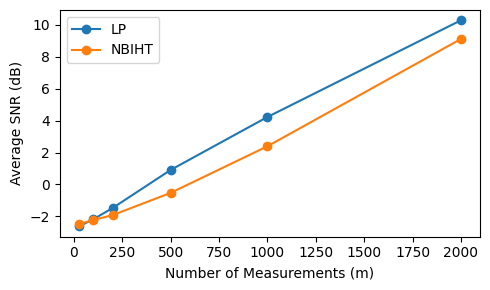

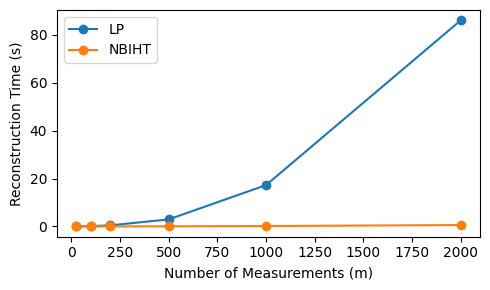

In [13]:
# Collect metrics for LP and NBIHT
lp_metrics = []
nbiht_metrics = []
lp_times = []
nbiht_times = []
ms = [25, 100, 200, 500, 1000, 2000]  # List of number of measurements

lp_recons = [X_hat_25_LP, X_hat_100_LP, X_hat_200_LP, X_hat_500_LP, X_hat_1000_LP, X_hat_2000_LP]
nbiht_recons = [X_hat_25_NBIHT, X_hat_100_NBIHT, X_hat_200_NBIHT, X_hat_500_NBIHT, X_hat_1000_NBIHT, X_hat_2000_NBIHT]

for i, m in enumerate(ms):
    X_hat = lp_recons[i]
    mse, snr = compute_metrics(X_hat, train_data[:, :X_hat.shape[1]])
    lp_metrics.append((mse, snr))
    lp_times.append(LP_times[i])
    print(f"LP Reconstruction with {m} measurements: MSE = {mse:.4e}, SNR = {snr:.4f}, Time = {LP_times[i]:.4f} s")

for i, m in enumerate(ms):
    X_hat = nbiht_recons[i]
    mse, snr = compute_metrics(X_hat, train_data[:, :X_hat.shape[1]])
    nbiht_metrics.append((mse, snr))
    nbiht_times.append(NBIHT_times[i])
    print(f"NBIHT Reconstruction with {m} measurements: MSE = {mse:.4e}, SNR = {snr:.4f}, Time = {NBIHT_times[i]:.4f} s")

# Plot metrics for LP and NBIHT

# Plot Average MSE vs Number of Measurements
plt.figure(figsize=(5, 3))
plt.plot(ms, [mse for mse, _ in lp_metrics], marker='o', label='LP')
plt.plot(ms, [mse for mse, _ in nbiht_metrics], marker='o', label='NBIHT')
plt.xlabel('Number of Measurements (m)')
plt.ylabel('Average MSE')
plt.legend()
plt.tight_layout()
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

# Plot Average SNR vs Number of Measurements
plt.figure(figsize=(5, 3))
plt.plot(ms, [snr for _, snr in lp_metrics], marker='o', label='LP')
plt.plot(ms, [snr for _, snr in nbiht_metrics], marker='o', label='NBIHT')
plt.xlabel('Number of Measurements (m)')
plt.ylabel('Average SNR (dB)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Reconstruction Time vs Number of Measurements
plt.figure(figsize=(5, 3))
plt.plot(ms, LP_times, marker='o', label='LP')
plt.plot(ms, NBIHT_times, marker='o', label='NBIHT')
plt.xlabel('Number of Measurements (m)')
plt.ylabel('Reconstruction Time (s)')
plt.legend()
plt.tight_layout()
plt.show()

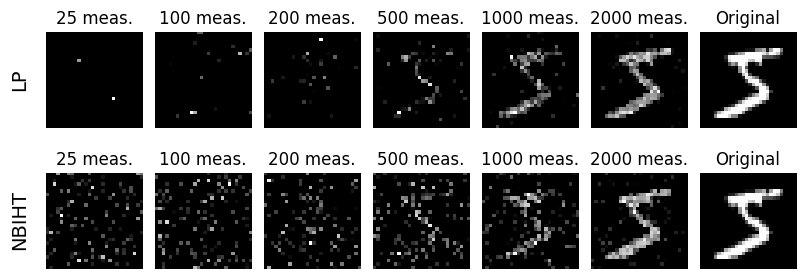

In [ ]:
# Create comparison of reconstructed images across methods and measurements

# Create subplot grid
fig, axes = plt.subplots(2, 7, figsize=(9, 3.5))

# Add row labels
fig.text(0.11, 0.65, 'LP', fontsize=14, rotation='vertical', va='center')
fig.text(0.11, 0.25, 'NBIHT', fontsize=14, rotation='vertical', va='center')

# Collect reconstructed images and measurements
lp_images = [X_hat_25_LP, X_hat_100_LP, X_hat_200_LP, X_hat_500_LP, X_hat_1000_LP, X_hat_2000_LP]
nbiht_images = [X_hat_25_NBIHT, X_hat_100_NBIHT, X_hat_200_NBIHT, X_hat_500_NBIHT, X_hat_1000_NBIHT, X_hat_2000_NBIHT]
ms = [25, 100, 200, 500, 1000, 2000]

# Plot reconstructed images
for i, (m, lp_img, x) in enumerate(zip(ms, lp_images, nbiht_images)):
    # Show LP reconstruction
    axes[0, i].imshow(lp_img[:, 0].reshape(28, 28), cmap='gray', vmin=0) #vmin=0 to ensure consistent brightness
    axes[0, i].set_title(f'{m} meas.')
    axes[0, i].axis('off')
    
    # Show NBIHT reconstruction
    axes[1, i].imshow(x[:, 0].reshape(28, 28), cmap='gray', vmin=0)
    axes[1, i].set_title(f'{m} meas.')
    axes[1, i].axis('off')

# Original image for reference
axes[0, i+1].imshow(train_data[:, 0].reshape(28, 28), cmap='gray', vmin=0)
axes[0, i+1].set_title('Original')
axes[0, i+1].axis('off')

axes[1, i+1].imshow(train_data[:, 0].reshape(28, 28), cmap='gray', vmin=0)
axes[1, i+1].set_title('Original')
axes[1, i+1].axis('off')

# Display the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85, left=0.15) 
plt.show()


In [26]:
# EXTRA: display NBIHT reconstruction for larger number of measurements
A3000 = normalise_columns(np.random.randn(3000, 784))
A4000 = normalise_columns(np.random.randn(4000, 784))
A5000 = normalise_columns(np.random.randn(5000, 784))
A6000 = normalise_columns(np.random.randn(6000, 784))
A7000 = normalise_columns(np.random.randn(7000, 784))
A8000 = normalise_columns(np.random.randn(8000, 784))

# Reconstruct images using NBIHT for larger number of measurements
ms = [25, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
image_idx = 0  # Index of the image to reconstruct

As = [A25, A100, A200, A500, A1000, A2000, A3000, A4000, A5000, A6000, A7000, A8000]

x_hats = []
times = []

for i, m in enumerate(ms):
    A = As[i]
    y = one_bit_measure(A, train_data[:, image_idx]).reshape(-1, 1)
    x_hat, t = batch_reconstruct_NBIHT(y, A, s, num_images=1)
    x_hats.append(x_hat)
    times.append(t)

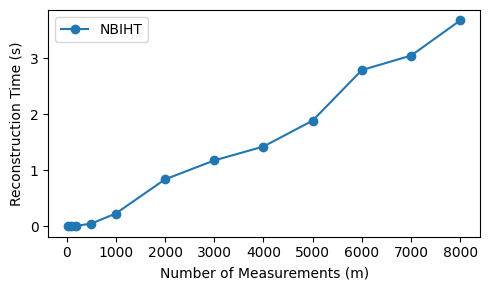

In [27]:
# Plot Reconstruction Time vs Number of Measurements for larger number of measurements
plt.figure(figsize=(5, 3))
plt.plot(ms, times, marker='o', label='NBIHT')
plt.xlabel('Number of Measurements (m)')
plt.ylabel('Reconstruction Time (s)')
plt.legend()
plt.tight_layout()
plt.show()


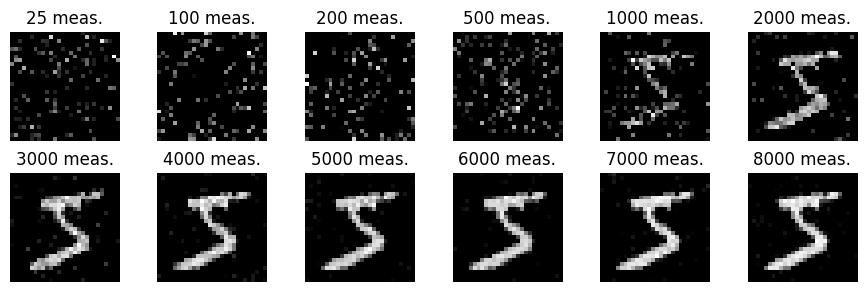

In [28]:
# Create subplot grid for larger number of measurements
fig, axes = plt.subplots(2, 6, figsize=(9, 3))

# Plot reconstructed images for larger number of measurements 
for i, (m, x) in enumerate(zip(ms, x_hats)):
    if i < 6:
        axes[0, i].imshow(x.reshape(28, 28), cmap='gray', vmin=0)
        axes[0, i].set_title(f'{m} meas.')
        axes[0, i].axis('off')
    else:
        axes[1, i-6].imshow(x.reshape(28, 28), cmap='gray', vmin=0)
        axes[1, i-6].set_title(f'{m} meas.')
        axes[1, i-6].axis('off')

plt.tight_layout()
plt.show()


NBIHT Reconstruction with 25 measurements: MSE = 2.1379e-03, SNR = -2.2431
NBIHT Reconstruction with 100 measurements: MSE = 2.3842e-03, SNR = -2.7165
NBIHT Reconstruction with 200 measurements: MSE = 2.1334e-03, SNR = -2.2339
NBIHT Reconstruction with 500 measurements: MSE = 1.5829e-03, SNR = -0.9378
NBIHT Reconstruction with 1000 measurements: MSE = 8.2779e-04, SNR = 1.8776
NBIHT Reconstruction with 2000 measurements: MSE = 2.1223e-04, SNR = 7.7888
NBIHT Reconstruction with 3000 measurements: MSE = 7.6939e-05, SNR = 12.1953
NBIHT Reconstruction with 4000 measurements: MSE = 3.4802e-05, SNR = 15.6408
NBIHT Reconstruction with 5000 measurements: MSE = 2.2678e-05, SNR = 17.5008
NBIHT Reconstruction with 6000 measurements: MSE = 1.3544e-05, SNR = 19.7394
NBIHT Reconstruction with 7000 measurements: MSE = 1.4416e-05, SNR = 19.4683
NBIHT Reconstruction with 8000 measurements: MSE = 1.1555e-05, SNR = 20.4292


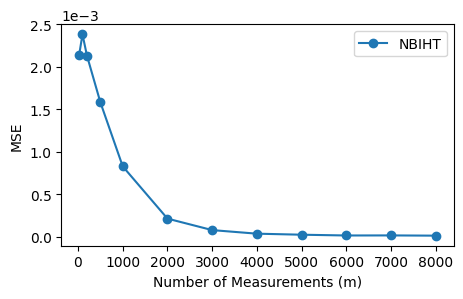

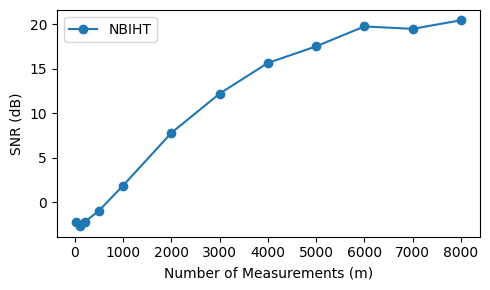

In [36]:
# Plot and display metrics for NBIHT

metrics = []

for i, m in enumerate(ms):
    mse, snr = compute_metrics(x_hats[i], train_data[:, image_idx].reshape(-1, 1))
    print(f"NBIHT Reconstruction with {m} measurements: MSE = {mse:.4e}, SNR = {snr:.4f}")

# Plot MSE vs Number of Measurements for larger number of measurements
plt.figure(figsize=(5, 3))
plt.plot(ms, [compute_metrics(x_hat, train_data[:, image_idx].reshape(-1, 1))[0] for x_hat in x_hats], marker='o', label='NBIHT')
plt.xlabel('Number of Measurements (m)')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

# Plot SNR vs Number of Measurements for larger number of measurements
plt.figure(figsize=(5, 3))
plt.plot(ms, [compute_metrics(x_hat, train_data[:, image_idx].reshape(-1, 1))[1] for x_hat in x_hats], marker='o', label='NBIHT')
plt.xlabel('Number of Measurements (m)')
plt.ylabel('SNR (dB)')
plt.legend()
plt.tight_layout()
plt.show()

